This notebook demonstrates how to classify an image provided by a URL, with a pre-trained image recognition model. It is mostly taken from the original gist [here](https://gist.github.com/jkarimi91/d393688c4d4cdb9251e3f939f138876e) with some small tweaks.

In [1]:
import io

from PIL import Image
import requests

import torch
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

We get the simple, short, human-readable labels for the 1000 ImageNet classes from [here](https://github.com/anishathalye/imagenet-simple-labels), such that we can map the predicted classes to the actual labels.

In [2]:
# Class labels used when training the models with ImageNet data
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'

response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in enumerate(response.json())}

In [3]:
# Random dog image taken from wikipedia
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Chin_posing.jpg/1920px-Chin_posing.jpg'

response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))

img.show()

Now that we have an image, we need to preprocess it, so that it meets the model requirements. From the PyTorch [documentation](https://pytorch.org/vision/stable/models.html),
> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

Note that these per-channel mean and std are calculated from the ImageNet data, which the models are trained upon. If we train our model from scratch, it would be better to use the mean and std of the actual training dataset. However, if we are only fine-tuning or directly querying the pre-trained models, it is better to use these pre-calculated values.

We use the following preprocessing pipeline to achieve this. Note that we resize the image to `(224, 224)`. If the original image is not square, it will be stretched.


In [4]:
min_img_size = 224
transform_pipeline = transforms.Compose([transforms.Resize((min_img_size, min_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

In [5]:
img_processed = transform_pipeline(img)

PyTorch pretrained models expect the Tensor dims to be `(num input imgs, num color channels, height, width)`. Currently however, we have `(num color channels, height, width)` since we only have one image. We insert a new axis at the index `0`.

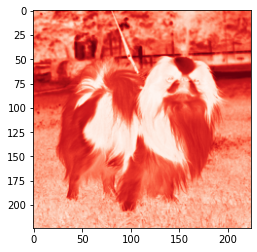

In [6]:
img_processed = img_processed.unsqueeze(0)

# The R channel of the preprocessed image
plt.imshow(img_processed[0, 0, :, :], cmap='Reds')
plt.show()

We then load the pretrained models, which may take a while to download for the first time. A full list of models available can be found [here](https://pytorch.org/vision/stable/models.html).

In [7]:
# model = models.vgg16(pretrained=True)
model = models.resnet152(pretrained=True)

In [8]:
# set evaluation mode, and get prediction
model.eval()

prediction = model(img_processed)

The original predictions are unbounded real numbers. We convert them to probabilities by applying the `softmax` transformation. We then print out and visualize the top 10 classes with the highest predicted probabilities.

In [9]:
sm = torch.nn.Softmax(dim=1)
proba = sm(prediction).detach().numpy()[0]

top_pred = {labels[x]: proba[x] for x in list((-proba).argsort())[:10]}
top_pred

{'Japanese Chin': 0.9897654,
 'Pekingese': 0.0047288844,
 'Papillon': 0.0023286233,
 'Tibetan Terrier': 0.00079975155,
 'Pomeranian': 0.00055672653,
 'Shih Tzu': 0.00045956078,
 'skunk': 0.00013133085,
 'marmoset': 0.00012289807,
 'Keeshond': 4.724084e-05,
 'Chihuahua': 4.6735637e-05}

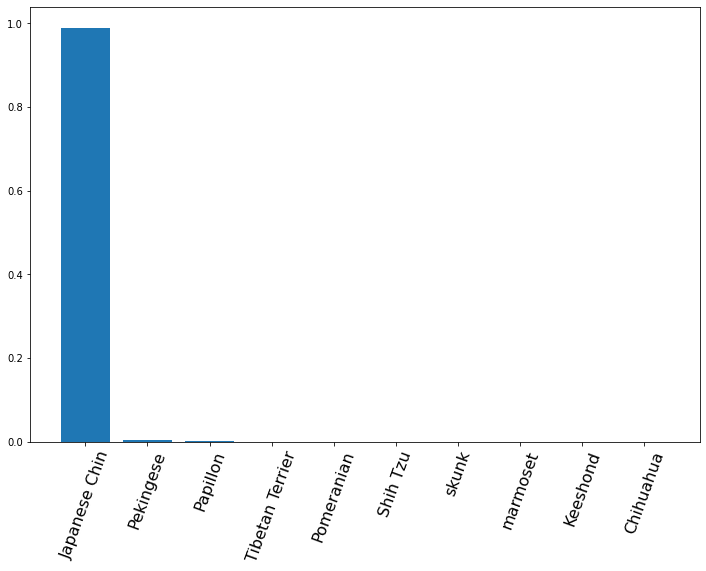

In [10]:
# visionalize the prediction
plt.rcParams["figure.figsize"] = (12,8)

plt.bar(range(len(top_pred)), list(top_pred.values()), align='center')
plt.xticks(range(len(top_pred)), list(top_pred.keys()), rotation=70, fontsize=16)
plt.show()